In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
# dataset = 'BigEarthNet'
dataset = 'EuroSAT'
prefix = 'c'
# prefix = ''
postfix = ''
# postfix = '_b'
model = f'{prefix}vit_base_patch16_224'
# name = f'mae_{prefix}vit{postfix}'
name  = f'mae_rca_vit'
metric = 'mAP' if dataset == 'BigEarthNet' else 'image_acc'

In [55]:
path = f'./results/logs/{dataset}_{model}_{name}/ft_metrics.csv'
df = pd.read_csv(path)
df.sort_values(by=[metric], inplace=True)

In [56]:
df

,epochs,lr,weight_decay,ce,loss,image_acc,epoch,num_samples
0,10,0.0050,0.05,1.717545,1.717545,0.350926,10,5400
1,10,0.0005,0.05,0.295543,0.295543,0.899630,10,5400
2,10,0.0001,0.05,0.277614,0.277614,0.909630,10,5400


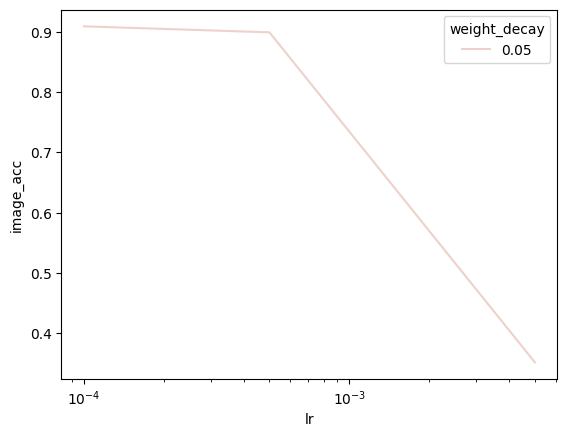

In [57]:
sns.lineplot(data=df, x='lr', y='image_acc', hue='weight_decay')
# set x axis log scale
plt.xscale('log')

In [58]:
path = f'./results/logs/{dataset}_{model}_{name}/lp_metrics.csv'
df = pd.read_csv(path)
df.sort_values(by=[metric], inplace=True)

In [59]:
df

,epochs,lr,weight_decay,ce,loss,image_acc,epoch,num_samples
6,100,0.001,0,0.503294,0.503294,0.853704,100,5400
5,100,0.005,0,0.357826,0.357826,0.891481,100,5400
4,100,0.010,0,0.320274,0.320274,0.902222,100,5400
3,100,0.050,0,0.280845,0.280845,0.911111,100,5400
1,100,0.300,0,0.377015,0.377015,0.911481,100,5400
2,100,0.100,0,0.273854,0.273854,0.911852,100,5400
0,100,0.200,0,0.297177,0.297177,0.912407,100,5400


<Axes: xlabel='lr', ylabel='image_acc'>

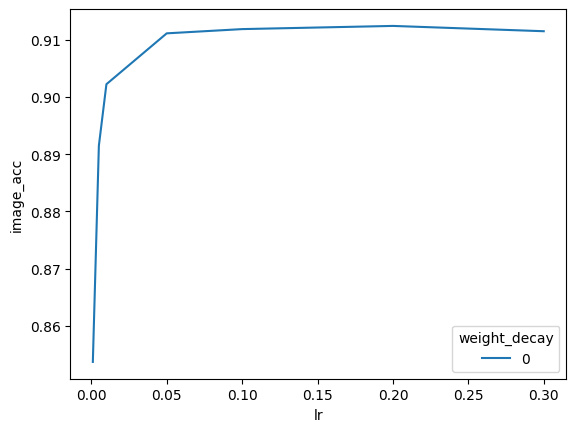

In [60]:
sns.lineplot(data=df, x='lr', y=metric, hue='weight_decay')